In [1]:
import numpy as np 
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDPMPipeline, DDIMScheduler
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
device

/media/mix060514/Data/pj/diffusers-test/venv/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


'cuda'

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

/media/mix060514/Data/pj/diffusers-test/venv/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


  0%|          | 0/40 [00:00<?, ?it/s]

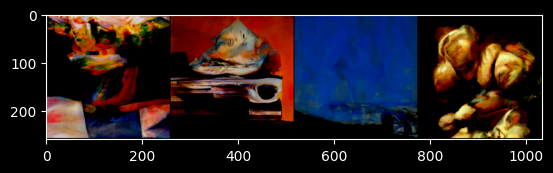

In [8]:
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)

scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)

x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noised_pred = image_pipe.unet(model_input, t)['sample']
    x = scheduler.step(noised_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1))

In [3]:
def color_loss(images, target_color=(.1, .9, .5)):
    target = (torch.tensor(target_color).to(images.device) * 2 - 1)
    target = target[None, :, None, None]
    error = torch.abs(images - target).mean()
    return error

  0%|          | 0/40 [00:00<?, ?it/s]

Step 0, loss: 29.826459884643555
Step 10, loss: 13.640241622924805
Step 20, loss: 12.882640838623047
Step 30, loss: 13.095287322998047


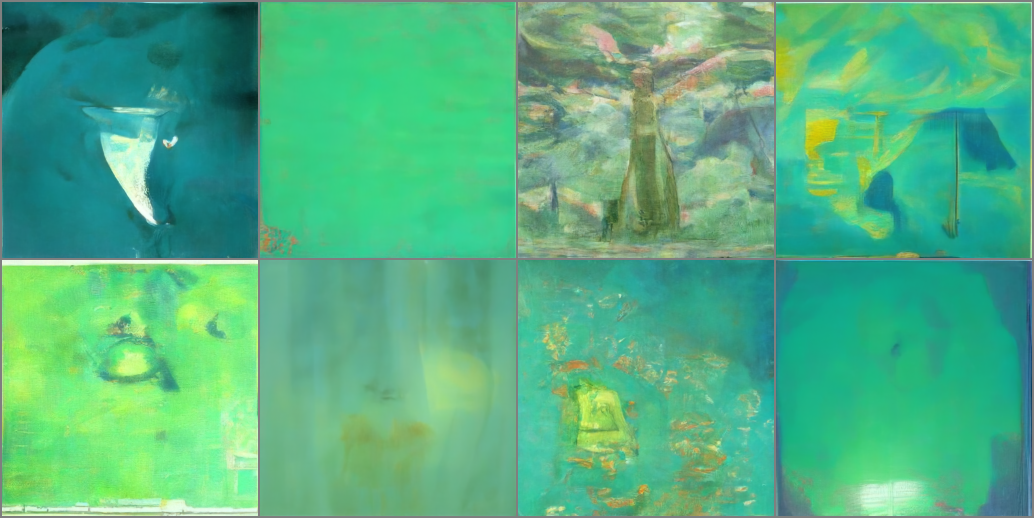

In [22]:
guidance_loss_scale = 40
x = torch.randn(8, 3, 256, 256).to(device)
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noised_pred = image_pipe.unet(model_input, t)['sample']
    x = x.detach().requires_grad_()
    x0 = scheduler.step(noised_pred, t, x).pred_original_sample
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(f"Step {i}, loss: {loss.item()}")
    cond_grad = - torch.autograd.grad(loss, x)[0]
    x = x.detach() + cond_grad
    x = scheduler.step(noised_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * .5 + .5
Image.fromarray((im.numpy() * 255).astype(np.uint8))

In [10]:
guidance_loss_scale = 40
x = torch.randn(2, 3, 256, 256).to(device)
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noised_pred = image_pipe.unet(model_input, t)['sample']
    x = x.detach().requires_grad_()
    model_input = scheduler.scale_model_input(x, t)
    noised_pred = image_pipe.unet(model_input, t)['sample']
    x0 = scheduler.step(noised_pred, t, x).pred_original_sample
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(f"Step {i}, loss: {loss.item()}")
    cond_grad = - torch.autograd.grad(loss, x)[0]
    x = x.detach() + cond_grad
    x = scheduler.step(noised_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * .5 + .5
Image.fromarray((im * 255).detach().numpy().astype(np.uint8))

  0%|          | 0/40 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 5.80 GiB of which 29.19 MiB is free. Including non-PyTorch memory, this process has 5.71 GiB memory in use. Of the allocated memory 5.41 GiB is allocated by PyTorch, and 194.05 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [9]:
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms("ViT-B/32", pretrained="openai")
clip_model = clip_model.to(device)

tfms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomAffine(5),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073],
        std=[0.26862954, 0.26130258, 0.27577711],
    ),
])

def clip_loss(image, text_features):
    image_features = clip_model.encode_image(
        tfms(image)
    )
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
    dists = (
        input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
    )
    return dists.mean()





  0%|          | 0/50 [00:00<?, ?it/s]

Step 0, loss: 7.229977607727051
Step 25, loss: 7.048116683959961


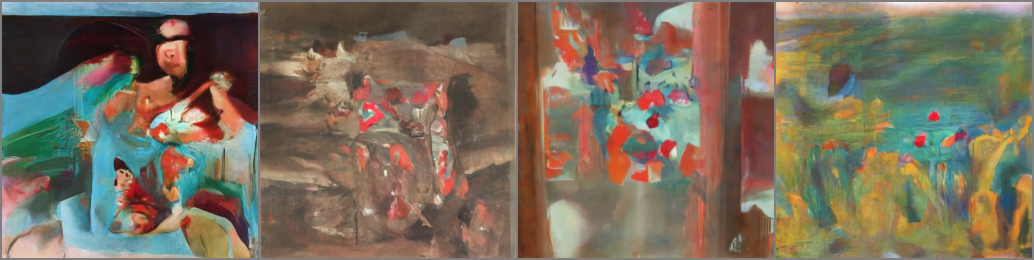

In [10]:
prompt = "Red Rose (still life), red flower painting"
guidance_loss_scale = 8
n_cuts = 4

scheduler.set_timesteps(50)
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)
x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noised_pred = image_pipe.unet(model_input, t)['sample']
    cond_grad = 0
    for cut in range(n_cuts):
        x = x.detach().requires_grad_()
        x0 = scheduler.step(noised_pred, t, x).pred_original_sample
        loss = clip_loss(x0, text_features) * guidance_loss_scale
        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts
    if i % 25 == 0:
        print(f"Step {i}, loss: {loss.item()}")
    alpha_bar = scheduler.alphas_cumprod[i]
    x = x.detach() + cond_grad * alpha_bar.sqrt()
    x = scheduler.step(noised_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * .5 + .5
Image.fromarray((im * 255).numpy().astype(np.uint8))


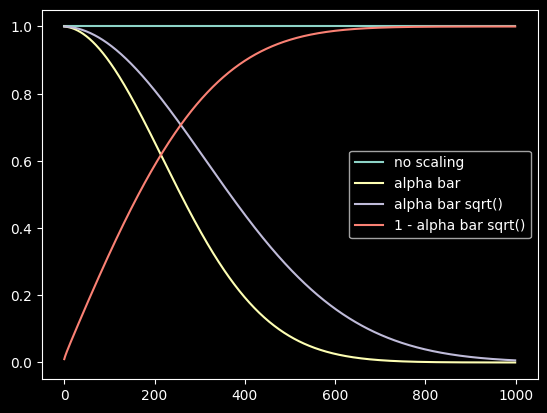

In [11]:
plt.plot([1 for a in scheduler.alphas_cumprod], label="no scaling")
plt.plot([a for a in scheduler.alphas_cumprod], label="alpha bar")
plt.plot([a.sqrt() for a in scheduler.alphas_cumprod], label="alpha bar sqrt()")
plt.plot([(1-a).sqrt() for a in scheduler.alphas_cumprod], label="1 - alpha bar sqrt()")
plt.legend()